In [11]:
# Install required packages
%pip install -e .

Obtaining file:///C:/Users/yecha/workspace/JPM-project/jpm-project
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for jpm-project (pyproject.toml): started
  Building editable for jpm-project (pyproject.toml): finished with status 'done'
  Created wheel for jpm-project: filename=jpm_project-0.1.0-0.editable-py3-none-any.whl size=4202 sha256=400c1e5d70abcb54a98d2da17e6cc9e79cf830aa181e55bd8d47ca62e1cd6076
  Stored in directory: C:\Users\yecha\AppData\Local\Temp\pip-ephem-wheel-cache-73m8_66v\wheels\7f\74\62\5598f11ff6462cac2e7

# Kalman Filter Demonstrations

This notebook demonstrates both the Linear Kalman Filter and Extended Kalman Filter implementations
from the `jpm-project` package. We'll show:

1. Linear KF on a simple constant + noise model
2. Extended KF on a nonlinear growth model
3. Visualization of results and comparison

In [12]:
# Import required libraries
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable OneDNN optimization warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from src.models.KalmanFilter import KalmanFilter
from src.models.ExtendedKalmanFilter import ExtendedKalmanFilter

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Linear Kalman Filter Example

First, we'll demonstrate the linear Kalman filter on a simple constant + noise model:

$x_t = x_{t-1} + q_t$  (state stays constant with noise)
$y_t = x_t + r_t$      (observe state with noise)

where $q_t \sim N(0, 0.1)$ and $r_t \sim N(0, 0.5)$ are process and observation noise.

In [13]:
# Generate synthetic data
T = 100  # number of time steps
true_state = 2.0  # true constant state
q_std = np.sqrt(0.1)  # process noise std
r_std = np.sqrt(0.5)  # observation noise std

# Generate true trajectory and noisy observations
states = np.zeros(T+1)
observations = np.zeros(T)

states[0] = true_state
for t in range(T):
    # State evolution: constant + noise
    states[t+1] = states[t] + np.random.normal(0, q_std)
    # Observe with noise
    observations[t] = states[t+1] + np.random.normal(0, r_std)

# Create and run Kalman filter
kf = KalmanFilter(
    transition_matrix=np.array([[1.0]]),      # state stays constant
    observation_matrix=np.array([[1.0]]),     # observe state directly
    transition_cov=np.array([[0.1]]),         # process noise variance
    observation_cov=np.array([[0.5]]),        # observation noise variance
    initial_mean=np.array([0.0]),             # start at zero
    initial_cov=np.array([[1.0]]),           # initial uncertainty
)

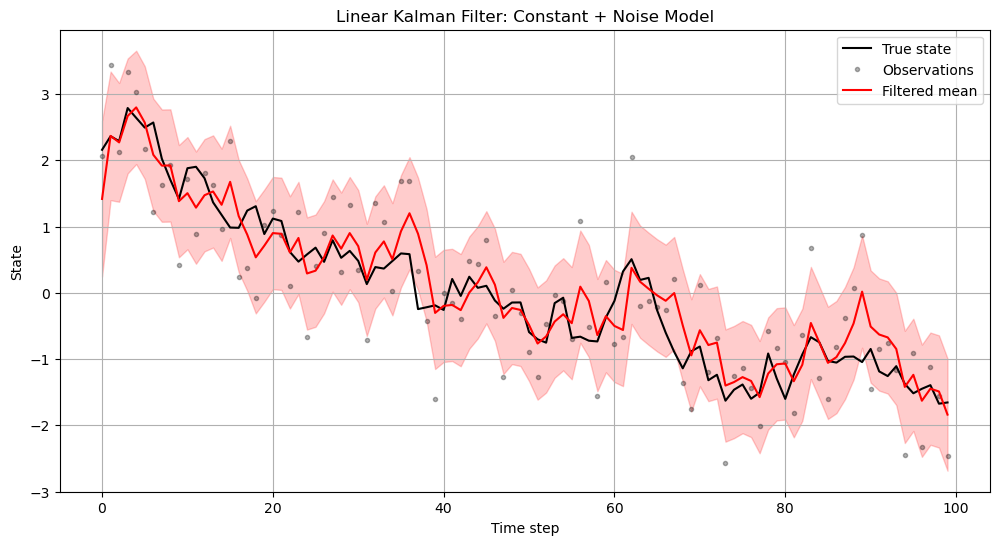

Log-likelihood: -131.62


In [14]:
# Run filter and get results
filtered_means, filtered_covs, loglik = kf.filter(observations.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
t = np.arange(T)
plt.plot(t, states[1:], 'k-', label='True state')
plt.plot(t, observations, 'k.', alpha=0.3, label='Observations')
plt.plot(t, filtered_means.numpy().squeeze(), 'r-', label='Filtered mean')

# Add uncertainty bands (2 standard deviations)
std = np.sqrt(np.array([cov[0,0] for cov in filtered_covs.numpy()]))
plt.fill_between(t, 
                filtered_means.numpy().squeeze() - 2*std,
                filtered_means.numpy().squeeze() + 2*std,
                color='r', alpha=0.2)

plt.xlabel('Time step')
plt.ylabel('State')
plt.title('Linear Kalman Filter: Constant + Noise Model')
plt.legend()
plt.grid(True)
plt.show()

print(f"Log-likelihood: {float(loglik):.2f}")

## 2. Extended Kalman Filter Example

Now we'll demonstrate the Extended Kalman Filter on a nonlinear growth model:

$x_t = x_{t-1} + 0.05x_{t-1}^2 + q_t$  (quadratic growth with noise)
$y_t = x_t + 0.1x_t^2 + r_t$           (quadratic observation with noise)

where $q_t \sim N(0, 0.01)$ and $r_t \sim N(0, 0.1)$. The system is nonlinear in both
state evolution and observation.

In [15]:
# Generate synthetic data for nonlinear system
T = 40  # fewer steps (system grows quickly)
from src.models.ExtendedKalmanFilter import _simulate_simple_nonlinear
true_x, obs_y, Q, R = _simulate_simple_nonlinear(T=T, seed=2)

# Define nonlinear functions using TensorFlow ops
def f(x: tf.Tensor) -> tf.Tensor:
    """State transition: x + 0.05x^2"""
    return x + 0.05 * tf.square(x)

def h(x: tf.Tensor) -> tf.Tensor:
    """Observation: x + 0.1x^2"""
    return x + 0.1 * tf.square(x)

# Create and run EKF
ekf = ExtendedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant([[Q]], dtype=tf.float64),
    R=tf.constant([[R]], dtype=tf.float64),
    initial_mean=tf.constant([0.0], dtype=tf.float64),
    initial_cov=tf.constant([[1.0]], dtype=tf.float64),
)

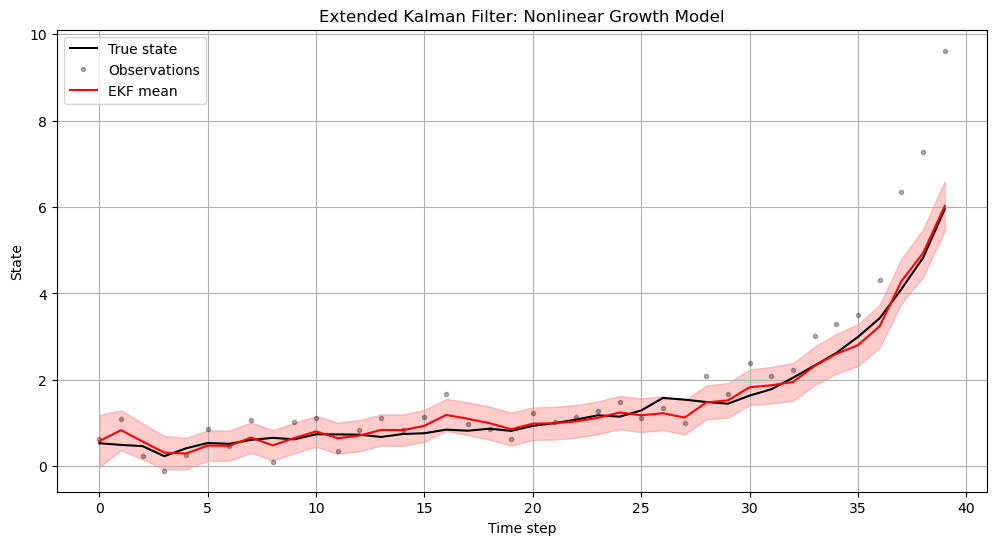

Log-likelihood: -24.68
RMSE: 0.157


In [16]:
# Run filter
filtered_means, filtered_covs, loglik = ekf.filter(obs_y)

# Plot results
plt.figure(figsize=(12, 6))
t = np.arange(T)
plt.plot(t, true_x, 'k-', label='True state')
plt.plot(t, obs_y, 'k.', alpha=0.3, label='Observations')
plt.plot(t, filtered_means.numpy().squeeze(), 'r-', label='EKF mean')

# Add uncertainty bands (2 standard deviations)
std = np.sqrt(np.array([cov[0,0] for cov in filtered_covs.numpy()]))
plt.fill_between(t, 
                filtered_means.numpy().squeeze() - 2*std,
                filtered_means.numpy().squeeze() + 2*std,
                color='r', alpha=0.2)

plt.xlabel('Time step')
plt.ylabel('State')
plt.title('Extended Kalman Filter: Nonlinear Growth Model')
plt.legend()
plt.grid(True)
plt.show()

print(f"Log-likelihood: {float(loglik):.2f}")

# Compute and print RMSE
rmse = np.sqrt(np.mean((filtered_means.numpy().squeeze() - true_x) ** 2))
print(f"RMSE: {rmse:.3f}")

## Notes on the Results

1. Linear Kalman Filter:
   - Works well for the constant + noise model
   - Uncertainty bands (±2σ) capture the true state reliably
   - Log-likelihood indicates how well the model fits the data

2. Extended Kalman Filter:
   - Handles the nonlinear growth model despite stronger nonlinearity
   - Uses automatic differentiation for Jacobians (no manual derivatives needed)
   - Uncertainty bands may be less reliable due to linearization
   - RMSE provides a measure of estimation accuracy

The EKF example demonstrates quadratic growth in both state evolution and observation.
Despite the nonlinearity, the filter tracks the state reasonably well, especially in
regions where the local linear approximation is adequate.

## 3. Unscented Kalman Filter Example

Now we'll apply the Unscented Kalman Filter to the same nonlinear growth model:

$x_t = x_{t-1} + 0.05x_{t-1}^2 + q_t$  (quadratic growth with noise)
$y_t = x_t + 0.1x_t^2 + r_t$           (quadratic observation with noise)

The UKF uses sigma points to handle nonlinearity without requiring Jacobians. This can be more accurate than EKF's linearization approach when the system is highly nonlinear.

In [17]:
# Import UKF
from src.models.UnscentedKalmanFilter import UnscentedKalmanFilter

# Create UKF - use same nonlinear functions and data as EKF
ukf = UnscentedKalmanFilter(
    f=f,  # same state transition as EKF
    h=h,  # same observation as EKF
    Q=tf.constant([[Q]], dtype=tf.float64),
    R=tf.constant([[R]], dtype=tf.float64),
    initial_mean=tf.constant([0.0], dtype=tf.float64),
    initial_cov=tf.constant([[1.0]], dtype=tf.float64),
    alpha=0.1,  # UKF tuning parameter - determines spread of sigma points
    beta=2.0,   # optimal for Gaussian priors
)

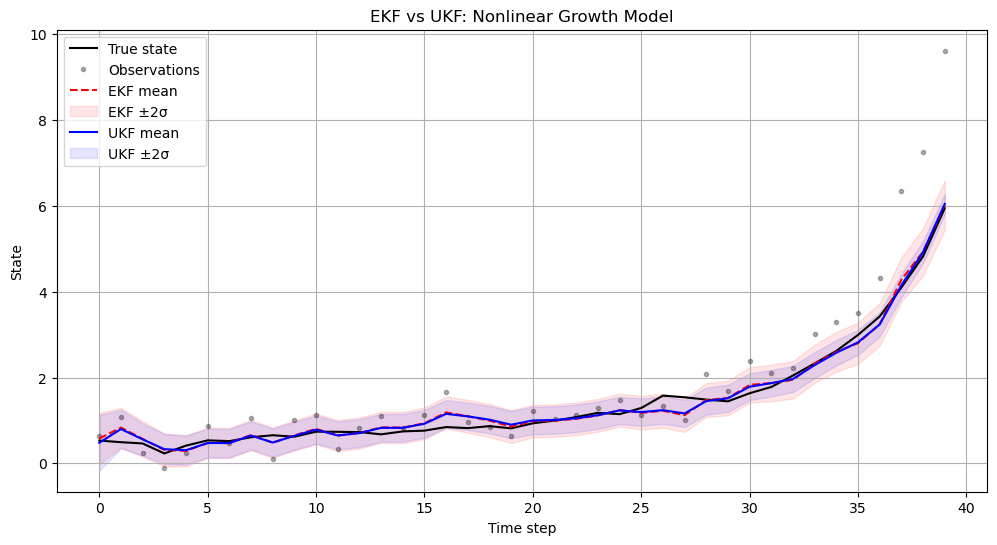

Comparison metrics:
EKF - Log-likelihood: -24.68, RMSE: 0.157
UKF - Log-likelihood: -23.08, RMSE: 0.145


In [18]:
# Run UKF and compare with EKF
ukf_means, ukf_covs, ukf_loglik = ukf.filter(obs_y)

# Plot results comparing UKF with EKF
plt.figure(figsize=(12, 6))
t = np.arange(T)

# True state and observations
plt.plot(t, true_x, 'k-', label='True state')
plt.plot(t, obs_y, 'k.', alpha=0.3, label='Observations')

# EKF results (dashed)
plt.plot(t, filtered_means.numpy().squeeze(), 'r--', label='EKF mean')
ekf_std = np.sqrt(np.array([cov[0,0] for cov in filtered_covs.numpy()]))
plt.fill_between(t, 
                filtered_means.numpy().squeeze() - 2*ekf_std,
                filtered_means.numpy().squeeze() + 2*ekf_std,
                color='r', alpha=0.1, label='EKF ±2σ')

# UKF results (solid)
plt.plot(t, ukf_means.numpy().squeeze(), 'b-', label='UKF mean')
ukf_std = np.sqrt(np.array([cov[0,0] for cov in ukf_covs.numpy()]))
plt.fill_between(t, 
                ukf_means.numpy().squeeze() - 2*ukf_std,
                ukf_means.numpy().squeeze() + 2*ukf_std,
                color='b', alpha=0.1, label='UKF ±2σ')

plt.xlabel('Time step')
plt.ylabel('State')
plt.title('EKF vs UKF: Nonlinear Growth Model')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics for comparison
ukf_rmse = np.sqrt(np.mean((ukf_means.numpy().squeeze() - true_x) ** 2))
print("Comparison metrics:")
print(f"EKF - Log-likelihood: {float(loglik):.2f}, RMSE: {rmse:.3f}")
print(f"UKF - Log-likelihood: {float(ukf_loglik):.2f}, RMSE: {ukf_rmse:.3f}")

## Comparing the Filters

The three filters (Linear KF, EKF, and UKF) demonstrate different approaches to state estimation:

1. Linear KF (Section 1):
   - Assumes linear dynamics and observation
   - Optimal for linear Gaussian systems
   - Used on constant + noise model

2. Extended KF (Section 2):
   - Handles nonlinearity through local linearization
   - Uses Jacobians (automatic differentiation)
   - May struggle with strong nonlinearity

3. Unscented KF (Section 3):
   - Handles nonlinearity using sigma points
   - No Jacobians needed
   - Often more accurate than EKF for highly nonlinear systems
   - Tunable via alpha (spread), beta (prior), kappa (scaling)

The nonlinear growth example shows how UKF and EKF compare on the same challenging system. Note that:
- Log-likelihood indicates how well each filter's predictions match the observations
- RMSE shows the actual estimation accuracy against the true state
- Uncertainty bounds (±2σ) reveal each filter's confidence in its estimates